## LLM API call using OpenAI API

### Tools

In [1]:
from openai import OpenAI
import os
import base64

# for plotting images
import matplotlib.pyplot as plt
from PIL import Image

### OpenAI client setup

In order to use OpenAI API you will need an OPEN_AI_KEY. You can create .env file with this line of code inside:

``OPENAI_API_KEY="YOUR_KEY_COMES_HERE" ``

Next, uncomment the code below to load the environment variable (API key) to your project.

In [2]:
# # load the env variable (API key)
# from dotenv import load_dotenv
# load_dotenv(dotenv_path=os.path.join(os.getcwd(), "..", ".env"), override=True) # works if the .env file is stored in the main project directory

In [2]:
# Use environment variables
key = os.getenv("OPENAI_API_KEY")

# construct client instance
client = OpenAI(api_key=key)

### Data

`*sample_path*` is where a sample used for prediction is stored. For now, a random image from the internet (of a likely melanoma) is used to test the system.

`*sample_probs_path*` is where probabilities output by the model for the sample are stored. 

`*xia_gradcam_output_path*` and `*xia_shap_output_path*` refer to the locations where xai output images are stored. Currently, I am using test images generated with ChatGPT.

`*xai_influence_output_path*` is where a mock output from the influence function is stored. Actual output should rank scores for training cases (samples) from the most to the least influencial for the current prediction. For our survey we can present 10 top influencial, but for the LLM call we should pass top 100 influencial cases (ranked by absolute scores), the model can then run some statistical analysis.   



In [3]:
sample_path = os.path.join(os.getcwd(), '../user_inputs/user_sample1.jpg')
sample_probs_path = os.path.join(os.getcwd(), '../results/xai_output/model_output.csv')  # Probabilities output by the model for the sample

xai_gradcam_output_path = os.path.join(os.getcwd(), '../results/xai_output/user_sample1_xai_gradcam.png')
xai_shap_output_path = os.path.join(os.getcwd(), '../results/xai_output/user_sample1_xai_shap.png')
xai_influence_output_path = os.path.join(os.getcwd(), '../results/xai_output/user_sample1_influence_function.csv')

In [4]:
# Function to encode the images to base64 byte objects in string format
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# encode the xai output images
xai_gradcam_enc = encode_image(xai_gradcam_output_path)
xai_shap_enc = encode_image(xai_shap_output_path)

# Read in the influence function output
with open(xai_influence_output_path, "r", encoding="utf-8") as f:
    xai_influence_function = f.read()

# Read in the sample probabilities output by the model
with open(sample_probs_path, "r",  encoding="utf-8") as f:
    sample_probs = f.read()

### Instructions

In constructing the instructions for LLM, I've followed OpenAI's best prompting practices available [here](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)

In [5]:
# read in the instructions
with open(os.path.join(os.getcwd(), "../data/llm/llm_instructions.md"), "r", encoding="utf-8") as f:
    instructions = f.read()

### LLM API call

We use a flagship model from OpenAI, GPT-4.1 (model snapshot: 2025-04-14). According to the company's documentation, it is highly capable at complex task while expressing strict adherance to instructions.  

In [6]:
response = client.responses.create(
    model="gpt-4.1-2025-04-14",
    input=[
        {
            "role": "developer",
            "content" : instructions
        },
        {
            "role": "user",
            "content": [
                { 
                    "type": "input_text",
                    "text": str(sample_probs) }, # sample probabilities
                { 
                    "type": "input_text",
                    "text": xai_influence_function }, # influence function output
                    
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{xai_gradcam_enc}", # GradCAM output, base64-encoded PNG file
                    "detail": "auto"
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{xai_shap_enc}", # SHAP output, base64-encoded PNG file
                    "detail": "auto"
                },

            ],
        }
    ],
    top_p=0.005
)

print(response.output_text)

**Summary**

The AI analysis suggests a borderline concern for malignancy in this skin lesion, with no clear preference for either benign or malignant classification.

**Confidence Level** 

The model is 51% confident in its prediction of malignancy, meaning there's a 49% chance this assessment could be incorrect.

**Key Findings**

- GradCAM: The heat map shows the AI paid closest attention to the two bright red areas in the centre of the image, suggesting these regions were most important for its decision. The blue area at the bottom contributed little to the model's decision.
- SHAP: The analysis shows a mix of red and green features scattered throughout the image. Red areas, especially in the lower left and lower right, moderately supported the prediction of malignancy, while green areas in the upper centre and other regions pushed the model toward a benign classification. Most features had only a moderate or weak influence.
- The focal areas in GradCAM and SHAP do not appear to be

In [7]:
response.usage.output_tokens

402

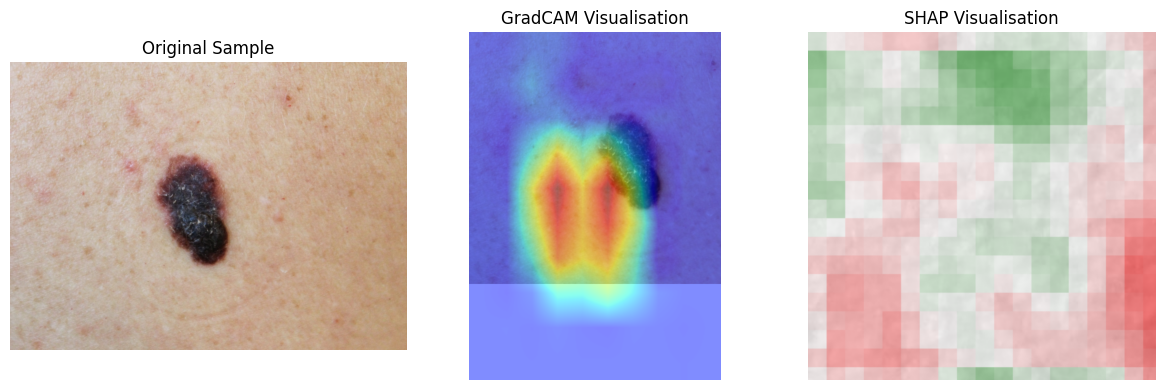

In [8]:
# Load and display xai images for context
img1 = Image.open(sample_path)
img2 = Image.open(xai_gradcam_output_path)
img3 = Image.open(xai_shap_output_path)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Original Sample')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('GradCAM Visualisation')
axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('SHAP Visualisation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
